# A. Libraries

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import albumentations as album

In [2]:
#!pip install --upgrade pip

In [3]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

# B. Read Data & Create train / validation splits

## 1. Read Data

In [4]:
#DATA_DIR = '/kaggle/input/deepglobe-road-extraction-dataset'
DATA_DIR = '/kaggle/input/deepglobe-road-extraction-dataset'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

## 2. Create train / valid splits

In [5]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


## 3. Shortlist specific classes to segment

In [6]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


# C. Helper functions for viz. & one-hot encoding/decoding

In [7]:
# helper function for data visualization
def visualize(**images):
    
    """
    Plot images in one row
    """
    
    n_images = len(images) #count number of images
    plt.figure(figsize=(20,8)) #set the figure size 20 by 8 inches
    for idx, (name, image) in enumerate(images.items()): #iterate through the images
        plt.subplot(1, n_images, idx + 1) #create a subplot for each image
        plt.xticks([]); #hide x ticks
        plt.yticks([]) #hide y ticks
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20) #set the title of the image
        plt.imshow(image) #show the image
    plt.show() #display the plot

# Perform one hot encoding on label
def one_hot_encode(label, label_values): #label is the image, label_values is the RGB values of the classes
    
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    
    semantic_map = [] #create an empty list
    for colour in label_values: #iterate through the RGB values of the classes
        equality = np.equal(label, colour) #check if the pixel value is equal to the RGB value of the class
        class_map = np.all(equality, axis = -1) #check if all the values in the array are True
        semantic_map.append(class_map) #append the class map to the semantic map list
    semantic_map = np.stack(semantic_map, axis=-1) #stack the semantic map list along the depth axis

    return semantic_map #return the semantic map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image): #image is the one-hot encoded image
    
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    
    x = np.argmax(image, axis = -1) #get the class key of the one-hot encoded image
    return x #return the class key

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values): #image is the class key, label_values is the RGB values of the classes
   
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values
    # Returns
        Colour coded image for segmentation visualization
    """
    
    colour_codes = np.array(label_values) #get the RGB values of the classes
    x = colour_codes[image.astype(int)] #get the RGB values of the classes based on the class key

    return x #return the RGB image

In [8]:
class RoadsDataset(torch.utils.data.Dataset):
    """
    DeepGlobe Road Extraction Challenge Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        df (DataFrame): DataFrame containing image and mask paths.
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask.
        augmentation (albumentations.Compose): Data augmentation pipeline (e.g., flip, scale, etc.).
        preprocessing (albumentations.Compose): Data preprocessing (e.g., normalization, shape manipulation, etc.).
        target_size (tuple): Target size for resizing images and masks.
        has_masks (bool): Whether the dataset includes masks.
    """

    def __init__(self, df, class_rgb_values=None, augmentation=None, preprocessing=None, target_size=(1024, 1024), has_masks=True):
        self.image_paths = df['sat_image_path'].tolist()  # Get the image paths
        self.has_masks = has_masks  # Whether masks are available

        if self.has_masks:
            self.mask_paths = df['mask_path'].tolist()  # Get the mask paths

        self.class_rgb_values = class_rgb_values  # RGB values of the classes
        self.augmentation = augmentation  # Augmentation pipeline
        self.preprocessing = preprocessing  # Preprocessing pipeline
        self.target_size = target_size  # Target size for resizing

    def __getitem__(self, i):
        # Load the image
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.target_size)

        if self.has_masks:
            # Load the mask if available
            mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
            mask = cv2.resize(mask, self.target_size)
            mask = one_hot_encode(mask, self.class_rgb_values).astype('float')  # One-hot encode the mask

            # Apply augmentation
            if self.augmentation:
                augmented = self.augmentation(image=image, mask=mask)
                image, mask = augmented['image'], augmented['mask']

            # Apply preprocessing
            if self.preprocessing:
                preprocessed = self.preprocessing(image=image, mask=mask)
                image, mask = preprocessed['image'], preprocessed['mask']

            return image, mask
        else:
            # Apply augmentation
            if self.augmentation:
                augmented = self.augmentation(image=image)
                image = augmented['image']

            # Apply preprocessing
            if self.preprocessing:
                preprocessed = self.preprocessing(image=image)
                image = preprocessed['image']

            return image

    def __len__(self):
        return len(self.image_paths)

In [9]:
def get_training_augmentation():                    #create a function to get the training augmentation
    train_transform = [                             #create a list of augmentations
        album.HorizontalFlip(p=0.5),                #apply horizontal flip with a probability of 0.5
        album.VerticalFlip(p=0.5),                  #apply vertical flip with a probability of 0.5
    ]
    return album.Compose(train_transform)           #return the augmentation


def to_tensor(x, **kwargs):                         #create a function to convert the image and mask to tensor
    return x.transpose(2, 0, 1).astype('float32')   #return the image and mask as a tensor


def get_preprocessing(preprocessing_fn=None):       #create a function to get the preprocessing transform

    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    
    _transform = []                                                     #create an empty list
    if preprocessing_fn:                                                #if preprocessing function is not None
        _transform.append(album.Lambda(image=preprocessing_fn))         #append the preprocessing function to the list
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))    #append the to_tensor function to the list
        
    return album.Compose(_transform)                                    #return the list as a Compose object

# D. Training DeepLabV3+

## 1. Model Definition

In [10]:
ENCODER = 'resnet50'            #encoder name
ENCODER_WEIGHTS = 'imagenet'    #encoder weights
CLASSES = select_classes        #classes
ACTIVATION = 'sigmoid'          #activation name

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(              #create a DeepLabV3Plus model
    encoder_name=ENCODER,               #encoder name
    encoder_weights=ENCODER_WEIGHTS,    #encoder weights
    classes=len(CLASSES),               #number of classes
    activation=ACTIVATION,              #activation function
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS) #get the preprocessing function

## 3. Set Model Hyperparams

In [11]:
import segmentation_models_pytorch.utils as smp_utils #import segmentation models pytorch utils

In [12]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [                                 #create a list of metrics
    smp.utils.metrics.IoU(threshold=0.5),   #IoU
]

# define optimizer
optimizer = torch.optim.Adam([                      #create an Adam optimizer
    dict(params=model.parameters(), lr=0.00008),    #set the learning rate
])

# define learning rate scheduler (not used in this NB)
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts( 
#    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
#)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/road-extraction-from-satellite-images-deeplabv3/best_model.pth'): #if the model checkpoint exists
    model = torch.load('../input/road-extraction-from-satellite-images-deeplabv3/best_model.pth', map_location=DEVICE) #load the model checkpoint
    print('Loaded pre-trained DeepLabV3+ model!') #print a message

# F. DEMO

In [13]:
# Create a DataFrame for the Test Folder

# Path to the test folder
TEST_DIR = '/kaggle/input/demo-pic'

# Create a DataFrame for the test images
test_metadata_df = pd.DataFrame({
    'sat_image_path': [os.path.join(TEST_DIR, img) for img in os.listdir(TEST_DIR)]
})

print(f"Number of test images: {len(test_metadata_df)}")

Number of test images: 6


In [14]:
# Create the Test Dataset and DataLoader

# Create the test dataset
test_dataset = RoadsDataset(
    test_metadata_df,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
    has_masks=False  # Specify that masks are not available
)

# Create the test DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [15]:
# Load the trained model
def load_trained_model(model_path, device):
    """
    Load the trained model from the specified path.
    """
    model = torch.load(model_path, map_location=device)
    model.eval()  # Set the model to evaluation mode
    print(f"Loaded model from {model_path}")
    return model

Loaded model from /kaggle/input/best_model/other/default/1/best_model.pth


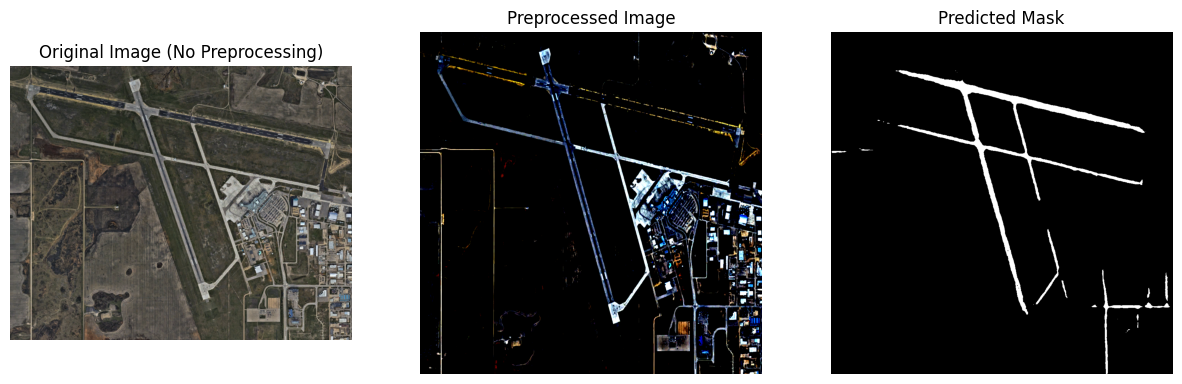

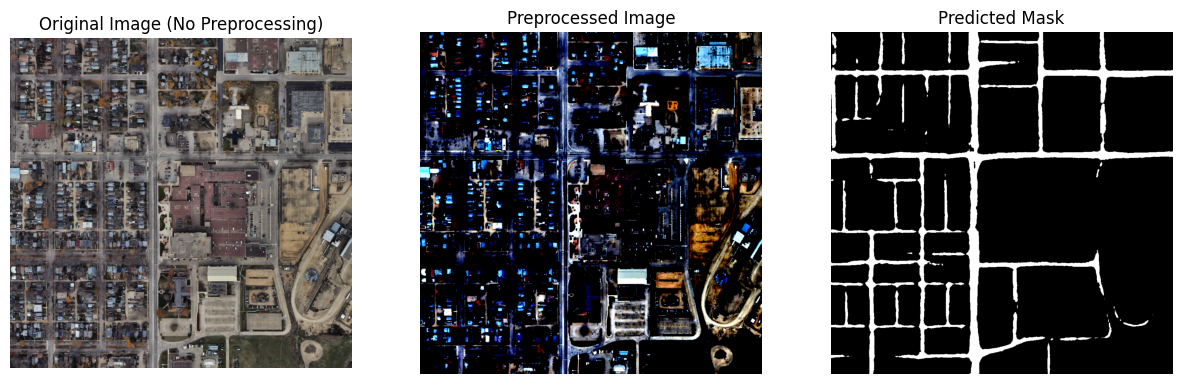

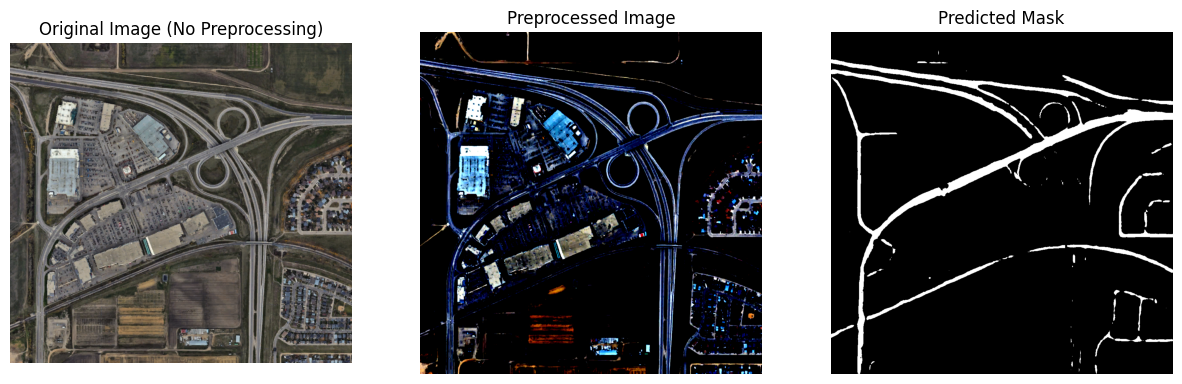

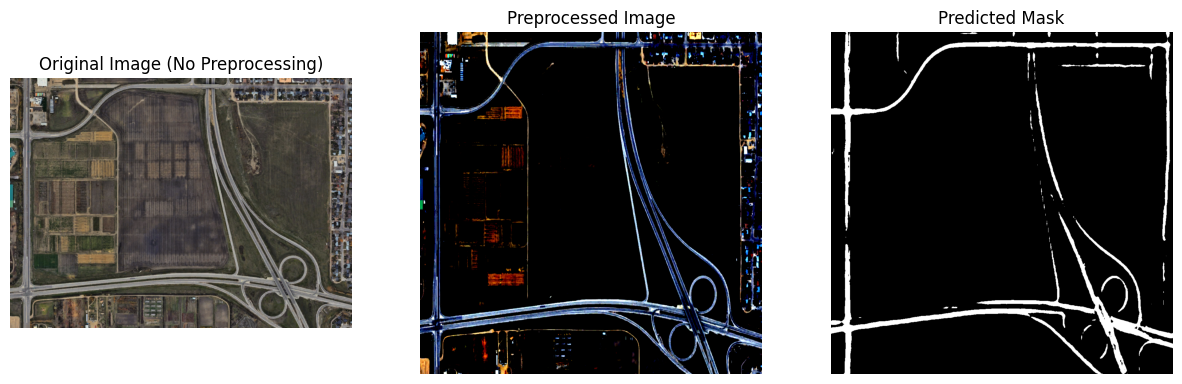

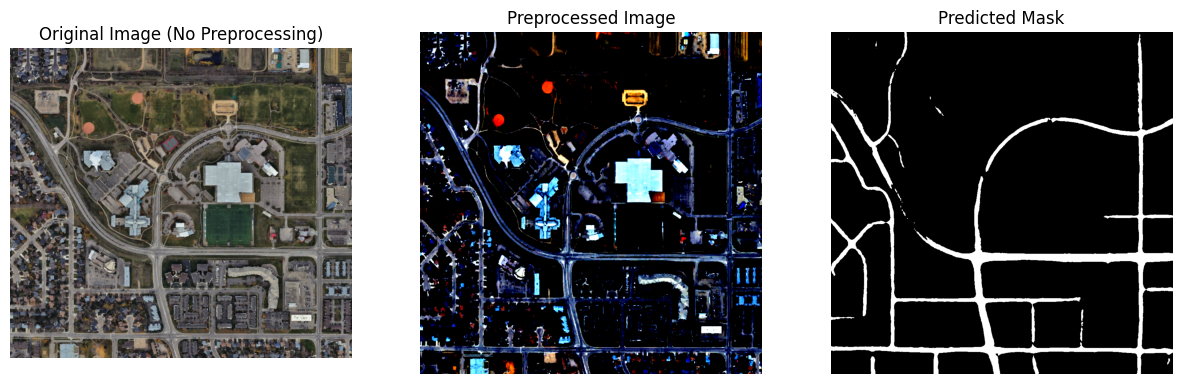

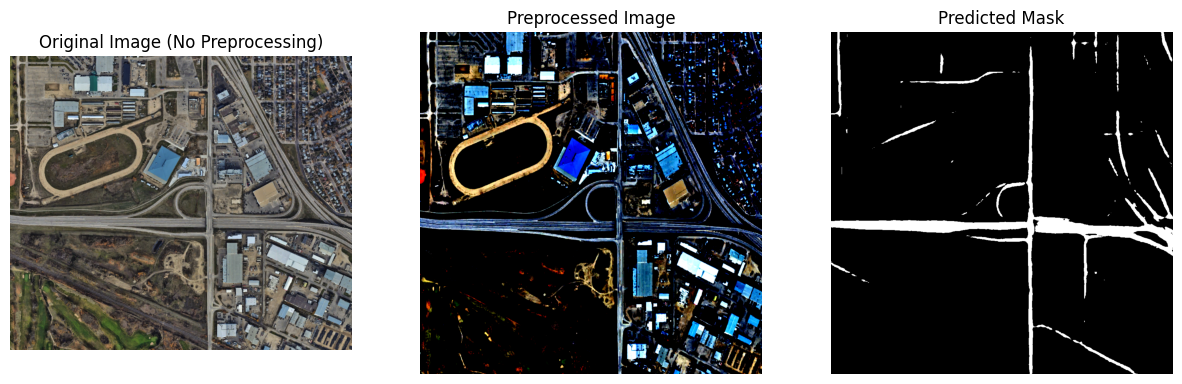

In [16]:
# Predict masks for the test images
def predict_and_visualize_with_original(model, test_dataloader, test_metadata_df, num_images_to_test, class_rgb_values, device):
    """
    Predict masks for the test images and visualize the results, including original images.

    Args:
        model: Trained model.
        test_dataloader: DataLoader for the test dataset.
        test_metadata_df: DataFrame containing metadata for test images (e.g., file paths).
        num_images_to_test: Number of images to test.
        class_rgb_values: RGB values for the classes.
        device: Device to run the model on (e.g., 'cuda' or 'cpu').
    """
    images_processed = 0

    for idx, image_batch in enumerate(test_dataloader):
        # Move the image batch to the device
        image_batch = image_batch.to(device)

        # Predict the mask
        with torch.no_grad():
            pred_masks = model(image_batch)
            pred_masks = pred_masks.cpu().numpy()  # Move the predictions to CPU

        # Process and visualize the predictions
        for i in range(image_batch.shape[0]):
            if images_processed >= num_images_to_test:
                return  # Stop once the desired number of images is processed

            # Load the original image (not preprocessed) for comparison
            original_image_path = test_metadata_df.iloc[images_processed]['sat_image_path']
            original_image = cv2.cvtColor(cv2.imread(original_image_path), cv2.COLOR_BGR2RGB)

            # Preprocessed image (used for prediction)
            preprocessed_image = image_batch[i].cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
            preprocessed_image = np.clip(preprocessed_image * 255, 0, 255).astype('uint8')  # Scale back to 0–255

            # Predicted mask
            predicted_mask = pred_masks[i].transpose(1, 2, 0)  # Convert CHW to HWC
            predicted_mask = colour_code_segmentation(reverse_one_hot(predicted_mask), class_rgb_values)

            # Visualize the original image, preprocessed image, and predicted mask
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.title("Original Image (No Preprocessing)")
            plt.imshow(original_image)
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title("Preprocessed Image")
            plt.imshow(preprocessed_image)
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(predicted_mask)
            plt.axis('off')

            plt.show()

            images_processed += 1

# Example usage
MODEL_PATH = '/kaggle/input/best_model/other/default/1/best_model.pth'  # Path to the trained model
NUM_IMAGES_TO_TEST = 100  # Number of images to test

# Load the trained model
best_model = load_trained_model(MODEL_PATH, DEVICE)

# Predict and visualize with original images
predict_and_visualize_with_original(best_model, test_dataloader, test_metadata_df, NUM_IMAGES_TO_TEST, select_class_rgb_values, DEVICE)